# NeuMF vs Diversified NeuMF vs MF

# Data

In [17]:
import os
import json
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

warnings.simplefilter(action="ignore", category=FutureWarning)

sns.set_style("whitegrid")
sns.set_palette("bright", 3)

In [18]:
interactions_df = pd.read_json(os.path.join("data", "interaction.json"))
interactions_df = interactions_df.drop(columns=[ "time" ], axis=1)
interactions_df

,id,participation,interaction_type,data
0,1,1,loaded-page,"{""page"": ""preference_elicitation"", ""context"": ..."
1,2,1,on-input,"{""search_text_box_value"": ""prada"", ""context"": ..."
2,3,1,selected-item,"{""selected_item"": {""movieName"": ""Devil Wears P..."
3,4,1,changed-viewport,"{""viewport"": {""left"": 0, ""top"": 0, ""width"": 19..."
4,5,1,on-input,"{""search_text_box_value"": ""mama"", ""context"": {..."
...,...,...,...,...
982,983,4,on-input,"{""id"": """", ""text"": ""Finish user study"", ""name""..."
983,984,4,iteration-ended,"{""iteration"": 5, ""selected"": [[863, 782, 410, ..."
984,985,4,study-ended,"{""iteration"": 5}"
985,986,4,loaded-page,"{""page"": ""finished_user_study"", ""context"": {""u..."


In [19]:
embeddings_df = pd.read_json(os.path.join("data", "movie_embeddings.json"))
embeddings_df

,movie_idx,embedding
0,8,"[-0.3509312868, 0.4983599782, -0.4398425519, 0..."
1,11,"[-0.2118005604, 0.5521904826, -0.2603289783, 0..."
2,14,"[0.4236060381, -0.20633351800000002, 0.3214513..."
3,22,"[-0.2169035971, -0.1967662573, -0.0951324999, ..."
4,27,"[0.012238361900000001, 0.4552696049, -1.066598..."
...,...,...
1925,1845,"[2.9959914684, -2.3926167488, 3.2849636078, -1..."
1926,1800,"[2.6797120571, -2.3741538525, 3.2547850609, -0..."
1927,1913,"[2.6833255291, -2.5622787476, 3.0506663322, -1..."
1928,1917,"[2.4284744263, -2.4721214771, 3.5537872314, -1..."


## Preprocessing

In [20]:
algorithm_map = { "A": "NEUMF", "B": "NEUMF_DIVERSITY", "C": "MF" }

names = list(algorithm_map.keys())
algorithms = list(algorithm_map.values())

# Add information on which iteration given record belongs to

def set_iteration_number(row):

    if row["interaction_type"] in [ "iteration-started", "iteration-ended" ]:

        row["iteration"] = json.loads(row["data"])["iteration"]

    else:

        row["iteration"] = None

    return row

interactions_df = interactions_df.apply(set_iteration_number, axis=1)

# Add information on iteration number to remaining records

interactions_df["iteration"] = interactions_df.groupby(["participation"], sort=False)["iteration"].ffill()
interactions_df: pd.DataFrame = interactions_df.dropna(subset=[ "iteration" ])
interactions_df["iteration"] = interactions_df["iteration"].astype(int)
interactions_df

,id,participation,interaction_type,data,iteration
29,30,1,iteration-started,"{""iteration"": 1, ""movies"": {""A"": {""movies"": [{...",1
30,31,1,loaded-page,"{""page"": ""compare_algorithms"", ""context"": {""ur...",1
31,32,1,changed-viewport,"{""viewport"": {""left"": 0, ""top"": 0, ""width"": 19...",1
32,33,1,changed-viewport,"{""viewport"": {""left"": 0, ""top"": -25, ""width"": ...",1
33,34,1,changed-viewport,"{""viewport"": {""left"": 0, ""top"": -342, ""width"":...",1
...,...,...,...,...,...
982,983,4,on-input,"{""id"": """", ""text"": ""Finish user study"", ""name""...",5
983,984,4,iteration-ended,"{""iteration"": 5, ""selected"": [[863, 782, 410, ...",5
984,985,4,study-ended,"{""iteration"": 5}",5
985,986,4,loaded-page,"{""page"": ""finished_user_study"", ""context"": {""u...",5


## Evaluation

### How many selections did each algorithm attract?

In [21]:
# Filter out selected items that were later deselected

sel_and_desel_items_df: pd.DataFrame = interactions_df[(interactions_df["interaction_type"] == "selected-item") | (interactions_df["interaction_type"] == "deselected-item")].copy()

def set_selected_item_idx(row):

    if row["interaction_type"] == "selected-item":

        row["movie_idx"] = json.loads(row["data"])["selected_item"]["movie_idx"]

    return row

def set_deselected_item_idx(row):

    if row["interaction_type"] == "deselected-item":

        row["movie_idx"] = json.loads(row["data"])["deselected_item"]["movie_idx"]

    return row

sel_and_desel_items_df = sel_and_desel_items_df.apply(set_selected_item_idx, axis=1)
sel_and_desel_items_df = sel_and_desel_items_df.apply(set_deselected_item_idx, axis=1)

deselected_item_rows_idxs = sel_and_desel_items_df[sel_and_desel_items_df["interaction_type"] == "deselected-item"].index

for i in deselected_item_rows_idxs:

    filter = (

        (sel_and_desel_items_df.index < i) &
        (sel_and_desel_items_df["participation"] == sel_and_desel_items_df.at[i, "participation"]) &
        (sel_and_desel_items_df["iteration"] == sel_and_desel_items_df.at[i, "iteration"]) &
        (sel_and_desel_items_df["movie_idx"] == sel_and_desel_items_df.at[i, "movie_idx"]) &
        (sel_and_desel_items_df["interaction_type"] == "selected-item")
    )
    
    sel_and_desel_items_df = sel_and_desel_items_df.drop(sel_and_desel_items_df[filter].index)

selected_items_df = sel_and_desel_items_df[sel_and_desel_items_df["interaction_type"] == "selected-item"].copy()

# Load lists of recommended items

iteration_started_df: pd.DataFrame = interactions_df[interactions_df["interaction_type"] == "iteration-started"].copy()

def set_recommended_items_idxs(row):

    data_as_json = json.loads(row["data"])

    for name in names:

        recommended_items_idxs = []

        for movie in data_as_json["movies"][name]["movies"]:

            recommended_items_idxs.append(movie["movie_idx"])

        row[algorithm_map[name]] = recommended_items_idxs

    return row

recommended_items_df = iteration_started_df.apply(set_recommended_items_idxs, axis=1)
recommended_items_df = recommended_items_df.drop(columns=[ "interaction_type", "data" ])

# Create DF with all selected items as selections in original dataset are counted only once, even if item is recommended by multiple algorithms

all_selections = []

for _, row in selected_items_df.iterrows():

    for algorithm in algorithms:

        if row["movie_idx"] in recommended_items_df.loc[(recommended_items_df["participation"] == row["participation"]) & (recommended_items_df["iteration"] == row["iteration"])].iloc[0][algorithm]:

            all_selections.append({ "participation": row["participation"], "iteration": row["iteration"], "movie_idx": row["movie_idx"], "algorithm": algorithm })

all_selected_items_df = pd.DataFrame(all_selections)
all_selected_items_df

,participation,iteration,movie_idx,algorithm
0,1,1,43,NEUMF
1,1,1,366,NEUMF
2,1,2,501,MF
3,1,2,667,MF
4,1,2,192,NEUMF_DIVERSITY
...,...,...,...,...
176,4,5,1456,MF
177,4,5,1181,MF
178,4,5,1491,NEUMF_DIVERSITY
179,4,5,748,MF


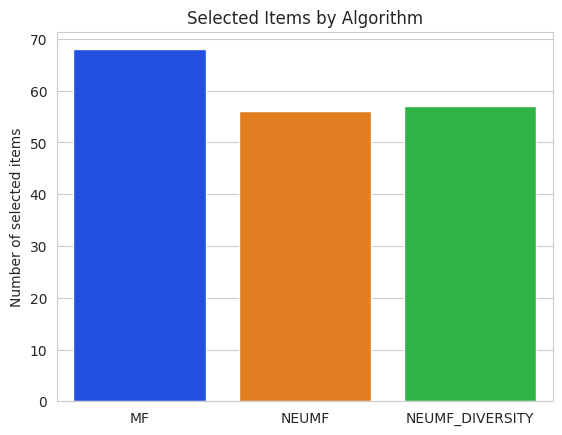

In [22]:
selections_counts = all_selected_items_df.groupby("algorithm")[["movie_idx"]].count().reset_index()

axis = sns.barplot(selections_counts, x="algorithm", y="movie_idx", hue="algorithm", legend=False)
axis.set(title="Selected Items by Algorithm", xlabel="", ylabel="Number of selected items")

plt.show()

### How did users rate each recommendation?

In [23]:
inputs_df = interactions_df.loc[interactions_df["interaction_type"] == "on-input"].copy()

def set_input_type(row):

    row["input_type"] = json.loads(row["data"])["input_type"]

    return row

inputs_df = inputs_df.apply(set_input_type, axis=1)

ratings_df: pd.DataFrame = inputs_df.loc[inputs_df["input_type"] == "rating"]

def set_rating_and_algorithm(row):

    data = json.loads(row["data"])

    row["rating"] = data["new_rating"]
    row["algorithm"] = algorithm_map[data["variant_name"]]

    return row

ratings_df = ratings_df.apply(set_rating_and_algorithm, axis=1)
ratings_df = ratings_df.drop_duplicates(subset=[ "participation", "iteration", "algorithm" ], keep="last")

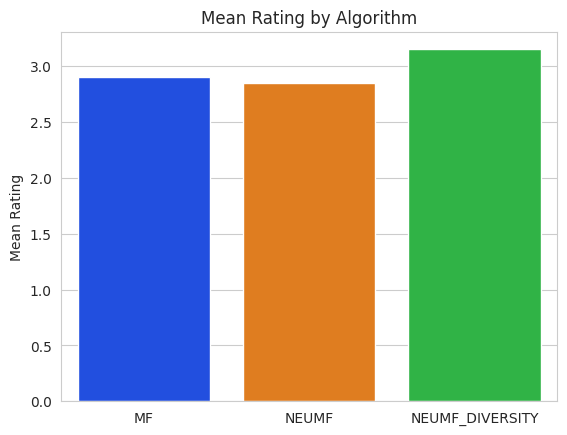

In [24]:
ratings_means = ratings_df.groupby("algorithm")[["rating"]].mean().reset_index()

axis = sns.barplot(ratings_means, x="algorithm", y="rating", hue="algorithm", legend=False)
axis.set(title="Mean Rating by Algorithm", xlabel="", ylabel="Mean Rating")

plt.show()

### Diversity with respect to genres

In [ ]:
iteration_started_df = interactions_df.loc[interactions_df["interaction_type"] == "iteration-started"].copy()

def calculate_intra_list_diversity_by_genres(row):

    data = json.loads(row["data"])

    for name in names:

        genres_of_movies: list[set] = []

        for movie in data["movies"][name]["movies"]:

            genres = set(movie["genres"])

            if len(genres) > 0:

                genres_of_movies.append(genres)

        diversities_sum = 0

        for i, g1 in enumerate(genres_of_movies):
            for j, g2 in enumerate(genres_of_movies):

                    if i < j:

                        jaccard_similarity = len(g1.intersection(g2)) / len(g1.union(g2))

                        diversities_sum += 1 - jaccard_similarity

        pairs_count = len(genres_of_movies) * (len(genres_of_movies) - 1) / 2

        intra_list_diversity = diversities_sum / pairs_count

        row[algorithm_map[name] + "_ILD_genres"] = intra_list_diversity

    return row

iteration_started_df = iteration_started_df.apply(calculate_intra_list_diversity_by_genres, axis=1)


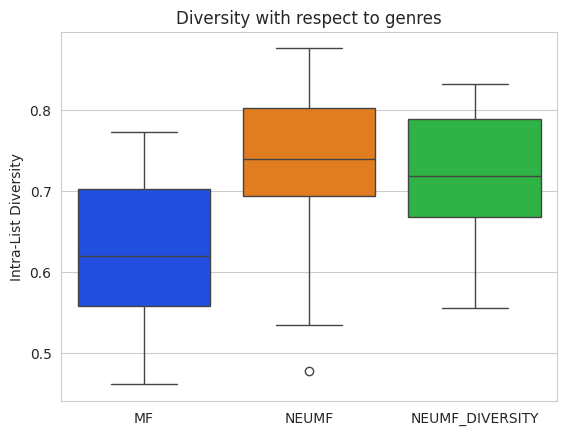

In [26]:
axis = sns.boxplot(data=iteration_started_df.rename(columns={ a + "_ILD_genres": a for a in algorithms })[sorted(algorithms)])
axis.set(title="Diversity with respect to genres", ylabel="Intra-List Diversity")

plt.show()

### Diversity with respect to embeddings

In [27]:
def calculate_intra_list_diversity_by_embeddings(row):

    data = json.loads(row["data"])

    for name in names:

        embeddings_of_movies = []

        for movie in data["movies"][name]["movies"]:

            embedding = embeddings_df.loc[embeddings_df["movie_idx"] == int(movie["movie_idx"])]["embedding"].to_numpy()[0]

            embeddings_of_movies.append(embedding)

        distances_sum = 0

        for i, e1 in enumerate(embeddings_of_movies):
            for j, e2 in enumerate(embeddings_of_movies):

                if i < j:

                    cosine_similarity = np.dot(e1, e2) / (np.linalg.norm(e1) * np.linalg.norm(e2))

                    distances_sum += 1 - cosine_similarity

        pairs_count = len(embeddings_of_movies) * (len(embeddings_of_movies) - 1) / 2

        intra_list_diversity = distances_sum / pairs_count

        row[algorithm_map[name] + "_ILD_embeddings"] = intra_list_diversity

    return row

iteration_started_df = iteration_started_df.apply(calculate_intra_list_diversity_by_embeddings, axis=1)

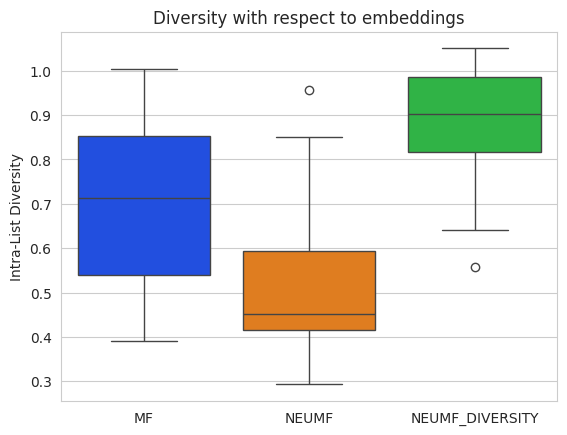

In [28]:
axis = sns.boxplot(data=iteration_started_df.rename(columns={ a + "_ILD_embeddings": a for a in algorithms })[sorted(algorithms)])
axis.set(title="Diversity with respect to embeddings", ylabel="Intra-List Diversity")

plt.show()